In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import cust_fun as cf
import torch.nn as nn
import torchvision.models as models
from sklearn.model_selection import train_test_split

In [ ]:
# 1.Data Process
# augmentation
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # 先调整到稍大的尺寸
    transforms.RandomRotation(90),  # 随机旋转
    transforms.RandomCrop(224),     # 随机裁剪到224x224
    transforms.RandomHorizontalFlip(p=0.2),  # 20%概率水平翻转
    transforms.RandomVerticalFlip(p=0.2),  # 20%概率垂直翻转
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 随机调整亮度、对比度和饱和度
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 随机平移±10%
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet预训练模型的标准化参数
                        std=[0.229, 0.224, 0.225])
])

# 验证集和测试集的transforms（只需要调整大小和标准化）
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

In [3]:
data_dir = "../../kaggle_data/classify-leaves"
train_dir = os.path.join(data_dir, "train.csv")
test_dir = os.path.join(data_dir, "test.csv")

In [4]:
# 2.ResNet-34
model = models.resnet34(weights = models.ResNet34_Weights.IMAGENET1K_V1)
model.fc = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(model.fc.in_features, 176))

# model = models.resnet50(num_classes=176)
# model.fc = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(model.fc.in_features, 176))
# state_dict = torch.load(os.path.join(data_dir, "resnet50model4.pth"), weights_only=False)
# model.load_state_dict(state_dict)

In [5]:
# 3.train data
df = pd.read_csv(train_dir)
df_train, df_valid = train_test_split(df, test_size=0.2, 
                                      random_state=42, stratify=df['label'])

train_dataset = cf.MyDataset(data_dir, dataf=df_train, 
                             transform=train_transforms, train=True)
valid_dataset = cf.MyDataset(data_dir, dataf=df_valid, 
                             transform=test_transforms, train=True)

batch_size = 64
nw = 2
train_iter = DataLoader(train_dataset, batch_size=batch_size, 
                        shuffle=True, num_workers=nw, pin_memory=True)
valid_iter = DataLoader(valid_dataset, batch_size=batch_size, 
                        shuffle=False, num_workers=nw, pin_memory=True)

Current learning rate: [1.2711661792704668e-06]
Epoch 058: train_loss=0.0311, train_acc=0.9877, val_loss=0.1786, val_acc=0.9436
  ⏹️ Early stopping triggered
4273.2 examples/sec on cuda:0
Current learning rate: [1.2711661792704668e-06]
Epoch 058: train_loss=0.0311, train_acc=0.9877, val_loss=0.1786, val_acc=0.9436


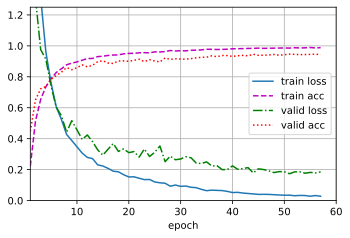

In [6]:
# 3.train adam
epochs, lr = 60, 1e-4
best_net = cf.best_model_ada(model, train_iter, valid_iter, epochs, lr, device='cuda:0')

In [ ]:
# 3.train sgd


In [7]:
train_dataset = cf.MyDataset(data_dir, train_dir, transform=train_transforms, train=True)
test_dataset = cf.MyDataset(data_dir, test_dir, transform=test_transforms, train=False)
test_iter = DataLoader(test_dataset, batch_size=batch_size*2, shuffle=False)

# best_net = model
# best_net.to('cuda')
best_net.eval()
results = []

with torch.no_grad():
    for images, filenames in test_iter:
        images = images.to('cuda')
        preds = best_net(images).argmax(1).cpu().numpy()

        for filename, pred in zip(filenames, preds):
            label = train_dataset.idx_to_class[pred]
            results.append((filename, label))

# 保存结果
subfile = os.path.join(data_dir, "submission4.csv")
submission = pd.DataFrame(results, columns=["image", "label"])
submission.to_csv(subfile, index=False, encoding="utf-8")

In [8]:
torch.save(best_net.state_dict(), os.path.join(data_dir, "resnet50model4.pth"))